In [92]:
import torch
from torch import nn
import numpy as np
import sklearn
from sklearn.datasets import make_circles, make_blobs
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 2 - Neural Network Classification with PyTorch

classification is a problem of whether something is one thing or another (there can be multiple things as the options)

## 1. Make classification data and get it ready


In [93]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)



In [94]:
len(X), len(y)

(1000, 1000)

In [95]:
print(f'First 5 samples of X: {X[:5]} ')
print(f'First 5 samples of y: \n{y[:5]}')

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] 
First 5 samples of y: 
[1 1 1 1 0]


In [96]:
# Make dataframe of circle data
circles = pd.DataFrame({'X1': X[:,0],
                        'X2': X[:,1],
                        'label': y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


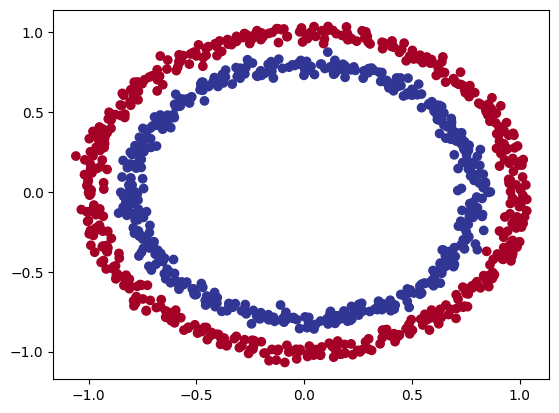

In [97]:
# Visualize
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)


### 1.1 Check input and output shapes

In [98]:
X.shape, y.shape,type(X),type(y)

((1000, 2), (1000,), numpy.ndarray, numpy.ndarray)

In [99]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

X_sample, y_sample, X_sample.shape, y_sample.shape, y_sample.ndim

(array([0.75424625, 0.23148074]), 1, (2,), (), 0)

### 1.2 Turning data into tensors and create train and test splits

In [100]:
# Turn data into tensor
X = torch.from_numpy(X).type(torch.float) # Change it to the default float32 from float64
y = torch.from_numpy(y).type(torch.float)

In [101]:
# Split data into traning and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42) # 20% is test 80% is for training

In [102]:
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Build a model to classify blue and red dot
To do so, we want to:
1. Setup device agnostic code os our code will run on GPU if there is one
2. Construct the model that is a subclass of 'nn.Module'
3. Define a loss function and optimizer
4. Create a training and test loop

### 2.1 Setting up device agnostic code

In [103]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 2.2 Create a model
1. subclass 'nn.Module'
2. Create 2 'nn.Linear()' layers that are capable of handling the shapes of our data
3. Define a 'forward()' method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model classs and send it to the target 'device'

In [104]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        # self.layer_1 = nn.Linear(in_features=2,
        #                          out_features=5) # takes in 2 features and upscales to 5 features
        # self.layer_2 = nn.Linear(in_features=5,
                                #  out_features=1) # takes in 5 from the previous layer and output a single feature (same shape as y)
        self.two_linear_layers = nn.Sequential(
                                                nn.Linear(in_features=2, out_features=5),
                                                nn.Linear(in_features=5, out_features=1)
                                            )
    # 3. Define a forward method that outlines the forward pass

    def forward(self, x):
        # return self.layer_2[self.layer_1[x]] # x -> layer_1 -> layer_2 -> output
        return self.two_linear_layers(x)

# 4. Instantiate an instnace of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [105]:
# Replicate what we have above with nn.Sequential()
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)

# model_0

In [106]:
model_0.state_dict()

OrderedDict([('two_linear_layers.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('two_linear_layers.0.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('two_linear_layers.1.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('two_linear_layers.1.bias', tensor([-0.2060], device='cuda:0'))])

In [107]:
# Make untrained predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f'Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
print(f'Length of test smaples: {len(X_test)}, Shape: {X_test.shape}')
print(f'\nFirst 10 predictions: \n{untrained_preds[:10]}')
print(f'\nFirst 10 labels: {y_test[:10]}')

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test smaples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], device='cuda:0')

First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [108]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.3 Set up loss function and optimizer

Which loss function and optimizer should you use?

This is problem specific

For regression you might want MAE or MSE(Mean Square Error)

For classification you might want binary cross entropy or categorical cross entropy (cross entropy)

For optimizers, two of the most common and useful are SGD and Adam. However PyTorch has many built-in options

* For the loss function we are using `torch.nn.BCEWithLogitsLoss()`


In [109]:
# Set up loss function
# loss_fn = nn.BCELoss() # this requires inputs to have gone through sigmoid activation prior to input to BCELoss()

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [110]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3, Train Model

Training loop:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimized (gradient descent)

### 3.1 Going from raw logits -> prediction probabilitites -> prediction labels

Our model ouputs are going to be raw **logits**

We can conert these **logits** into prediction probabilities by passing them through some kind of activation function (e.g. sigmoid for binary classfication and softmax for multiclass classfication)

Then we can convert our model prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [111]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits, y_test[:5]

(tensor([[-0.1269],
         [-0.0967],
         [-0.1908],
         [-0.1089],
         [-0.1667]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.]))

In [112]:
# Use sigmoid activation funtion on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], device='cuda:0')

For our prediction probabilities values. we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y = 1` (class 1)
* `y_pred_probs` <= 0.5, `y = 0` (class 0)


In [113]:
# Turning pred probs. into actual labels
y_preds = torch.round(y_pred_probs)

# In full logits -> pred prob -> pred labels
model_0.eval()
with torch.inference_mode():
    y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze())) # Get rid of the extra dimension



y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

### 3.2 Building a training and test loop

In [114]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs
epochs = 100

# Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop

for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

    # 2. Calculate the loss
    loss = loss_fn(y_logits,
                   y_train)        # Our loss function is BCEWithLogitsLoss, it expects logits as input, While BCELoss function expects pred probs as input
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (Gradient Descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward Pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test) # Prediction comes first and then true labels
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what is happening
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test Acc: {test_acc:.5f}')



Epoch: 0 | Loss: 0.69569, Acc: 50.00 | Test loss: 0.69721, Test Acc: 50.00000
Epoch: 10 | Loss: 0.69403, Acc: 50.00 | Test loss: 0.69615, Test Acc: 50.00000
Epoch: 20 | Loss: 0.69343, Acc: 46.00 | Test loss: 0.69585, Test Acc: 48.50000
Epoch: 30 | Loss: 0.69321, Acc: 49.00 | Test loss: 0.69577, Test Acc: 47.50000
Epoch: 40 | Loss: 0.69312, Acc: 49.50 | Test loss: 0.69573, Test Acc: 46.50000
Epoch: 50 | Loss: 0.69308, Acc: 50.38 | Test loss: 0.69569, Test Acc: 46.50000
Epoch: 60 | Loss: 0.69306, Acc: 50.50 | Test loss: 0.69564, Test Acc: 46.50000
Epoch: 70 | Loss: 0.69305, Acc: 50.50 | Test loss: 0.69559, Test Acc: 46.50000
Epoch: 80 | Loss: 0.69304, Acc: 50.75 | Test loss: 0.69553, Test Acc: 46.50000
Epoch: 90 | Loss: 0.69303, Acc: 50.38 | Test loss: 0.69547, Test Acc: 46.50000


## 4. Make predictions and evaluate the model

from the metrics it looks like the model is not learning anything

VISUALIZE
We are going to import a function called `plot_decision_boundary()`

In [115]:
import requests
from pathlib import Path

# Download helper function from Learn PyTorch repo if it is not downloaded already
if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists')
else:
    print('Downloading helper_functions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists


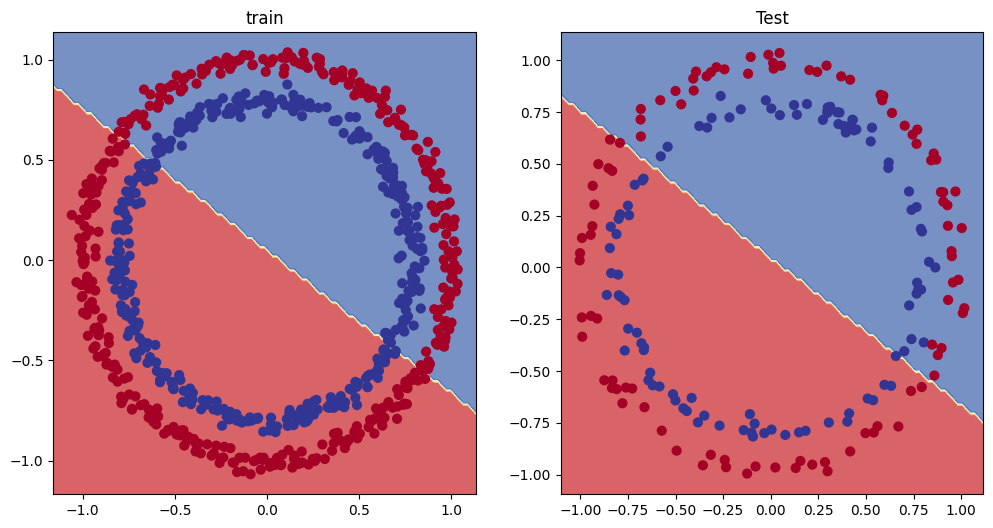

In [116]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model's perspective)

Potential Options:

* Add more layer - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 units
* More epochs
* Changing the activation functions
* Change the learning rate
* Change the loss function

**Note:** these are all from a model's perspective because they deal directly with the model, rather than the data

And because these options are all values we as machine learning engineers and data scientists can change, they are referred to as **hyperparameters**.

Let's try and improve models by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [117]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1, model_1.state_dict()


(CircleModelV1(
   (layer_1): Linear(in_features=2, out_features=10, bias=True)
   (layer_2): Linear(in_features=10, out_features=10, bias=True)
   (layer_3): Linear(in_features=10, out_features=1, bias=True)
 ),
 OrderedDict([('layer_1.weight',
               tensor([[ 0.5406,  0.5869],
                       [-0.1657,  0.6496],
                       [-0.1549,  0.1427],
                       [-0.3443,  0.4153],
                       [ 0.6233, -0.5188],
                       [ 0.6146,  0.1323],
                       [ 0.5224,  0.0958],
                       [ 0.3410, -0.0998],
                       [ 0.5451,  0.1045],
                       [-0.3301,  0.1802]], device='cuda:0')),
              ('layer_1.bias',
               tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                        0.0667, -0.6984], device='cuda:0')),
              ('layer_2.weight',
               tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.049

In [118]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)

In [119]:
# Training loop and test/eval loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid((y_logits)))

    # 2. Calculate the Loss/Acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Zero the optimizer gradient
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (This is where adjustments of all model parameters will take place)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calculate the loss
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what is happening
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}%| Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}% ')

Epoch: 0 | Loss: 0.69396, Acc: 50.88%| Test loss: 0.69261, Test acc: 51.00% 
Epoch: 100 | Loss: 0.69305, Acc: 50.38%| Test loss: 0.69379, Test acc: 48.00% 
Epoch: 200 | Loss: 0.69299, Acc: 51.12%| Test loss: 0.69437, Test acc: 46.00% 
Epoch: 300 | Loss: 0.69298, Acc: 51.62%| Test loss: 0.69458, Test acc: 45.00% 
Epoch: 400 | Loss: 0.69298, Acc: 51.12%| Test loss: 0.69465, Test acc: 46.00% 
Epoch: 500 | Loss: 0.69298, Acc: 51.00%| Test loss: 0.69467, Test acc: 46.00% 
Epoch: 600 | Loss: 0.69298, Acc: 51.00%| Test loss: 0.69468, Test acc: 46.00% 
Epoch: 700 | Loss: 0.69298, Acc: 51.00%| Test loss: 0.69468, Test acc: 46.00% 
Epoch: 800 | Loss: 0.69298, Acc: 51.00%| Test loss: 0.69468, Test acc: 46.00% 
Epoch: 900 | Loss: 0.69298, Acc: 51.00%| Test loss: 0.69468, Test acc: 46.00% 


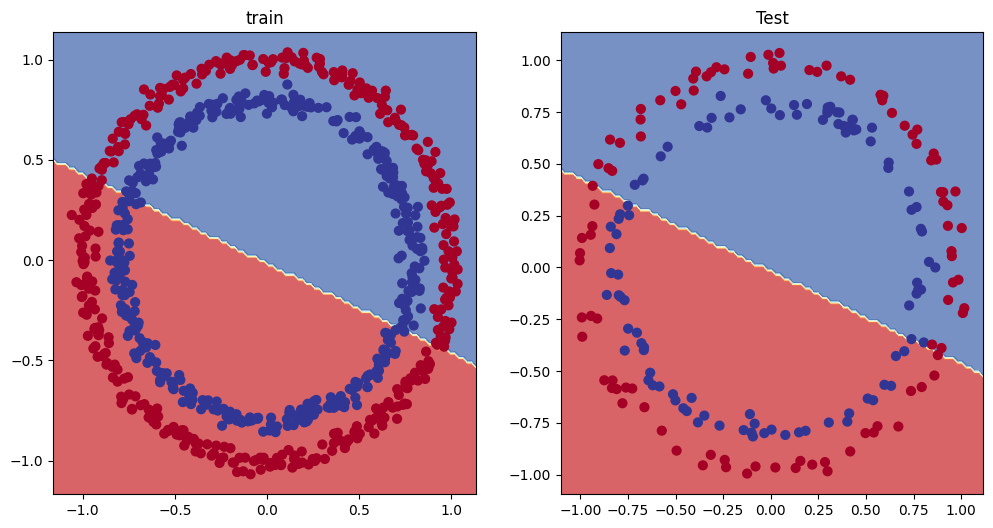

In [120]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 preparing data t osee if our model can fit a straight line

One way to trouble shoot a larger problem is to test out a smaller problem

In [121]:
# Create some data(same as notebook 1)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check teh data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [122]:
# Create train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the len of each
len(X_train_regression), len(X_test_regression),len(y_train_regression)

(80, 20, 80)

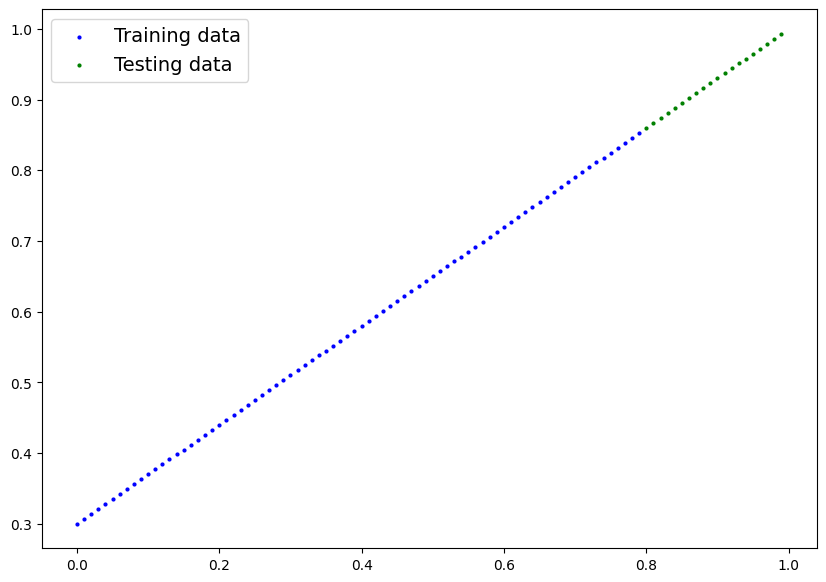

In [123]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 adjusting `model_1` to fit a straight line

In [124]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [125]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [126]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

#Training
for epoch in range(epochs):
    model_2.train()

    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred,y_test_regression)
    # print our what is happening
    if epoch % 100 == 0:
        print(epoch, loss, test_loss,)


0 tensor(0.7599, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.9110, device='cuda:0')
100 tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0008, device='cuda:0')
200 tensor(0.0253, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0021, device='cuda:0')
300 tensor(0.0214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0031, device='cuda:0')
400 tensor(0.0196, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0034, device='cuda:0')
500 tensor(0.0194, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0039, device='cuda:0')
600 tensor(0.0190, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0038, device='cuda:0')
700 tensor(0.0188, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0038, device='cuda:0')
800 tensor(0.0184, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0033, device='cuda:0')
900 tensor(0.0180, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0036, device='cuda:0')


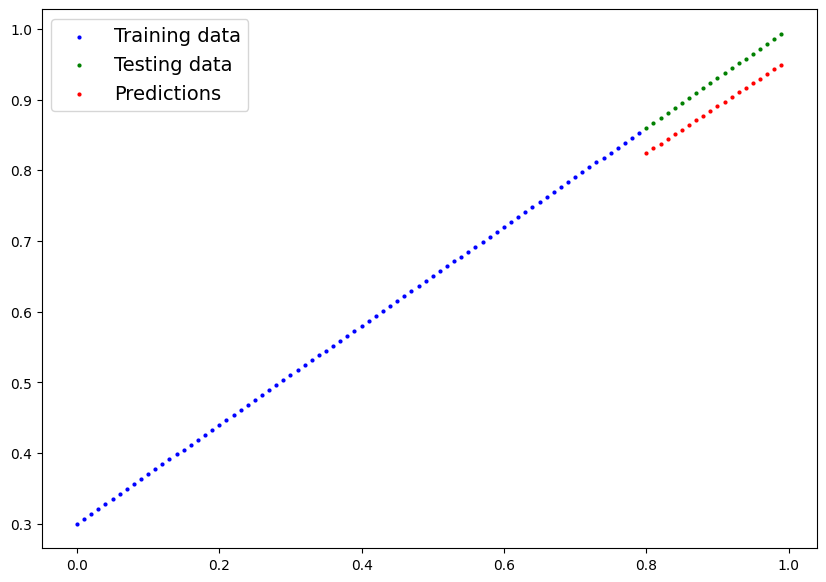

In [127]:
# Turn on eval mode
model_2.eval()

# Make predictions
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu().numpy(),
                 train_labels=y_train_regression.cpu().numpy(),
                 test_data=X_test_regression.cpu().numpy(),
                 test_labels=y_test_regression.cpu().numpy(),
                 predictions=test_pred.cpu().numpy())

## 6. The missing piece: Non-Linearity


### 6.1 Recreating non-linear data (red and blue circles)

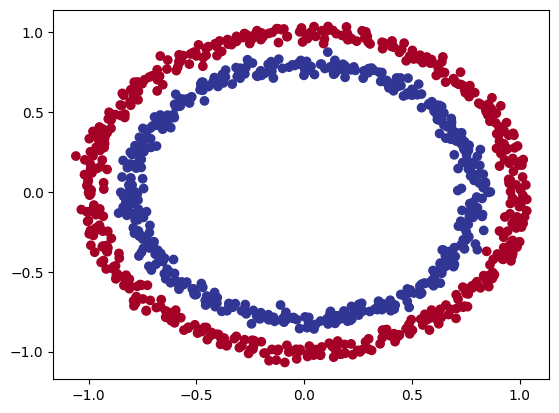

In [128]:
n_samples = 1000

X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [129]:
# Convert data to tensors then to do the split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

### 6.2 Building a model with non-linearity


In [130]:
# Build a model with non-linear activation function
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # This is non-linear
    def forward(self, x):
        # Where should we put our non-linear activation funtion
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [131]:
# Set up loss and optimizer functino
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)


### 6.3 Training a model with non-linearity

In [132]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Loss function
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero_grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. step the optimizer
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what is happening
    if epoch % 100 == 0:
        print(epoch, loss, acc, test_loss, test_acc)

0 tensor(0.6929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 50.0 tensor(0.6932, device='cuda:0') 50.0
100 tensor(0.6912, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 52.87500000000001 tensor(0.6910, device='cuda:0') 52.5
200 tensor(0.6898, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 53.37499999999999 tensor(0.6894, device='cuda:0') 55.00000000000001
300 tensor(0.6879, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 53.0 tensor(0.6872, device='cuda:0') 56.00000000000001
400 tensor(0.6852, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 52.75 tensor(0.6841, device='cuda:0') 56.49999999999999
500 tensor(0.6810, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 52.75 tensor(0.6794, device='cuda:0') 56.49999999999999
600 tensor(0.6751, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 54.50000000000001 tensor(0

### 6.4 Evaluating a model trained with non-linear activation function

In [133]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

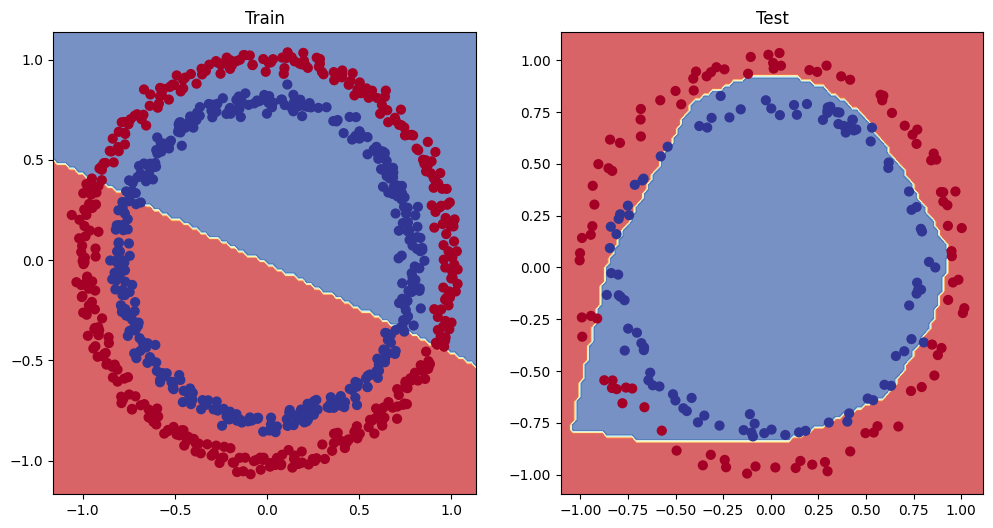

In [134]:
# Plot the decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

In [135]:
# Create a tensor
A = torch.arange(-10,10,1,dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

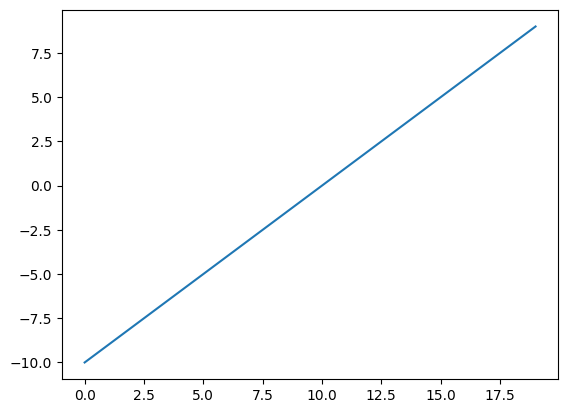

In [136]:
# Visualize the tensor
plt.plot(A)

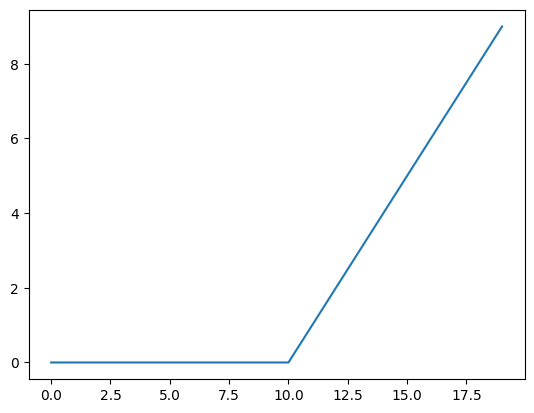

In [137]:
plt.plot(torch.relu(A))

In [138]:
def relu(x:torch.tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # Input must be tensor

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

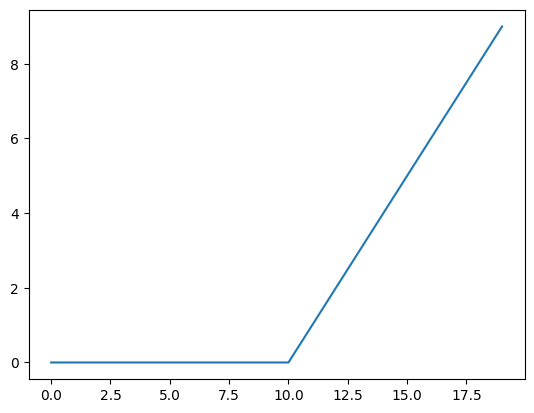

In [139]:
# Plot ReLu activation function
plt.plot(relu(A))

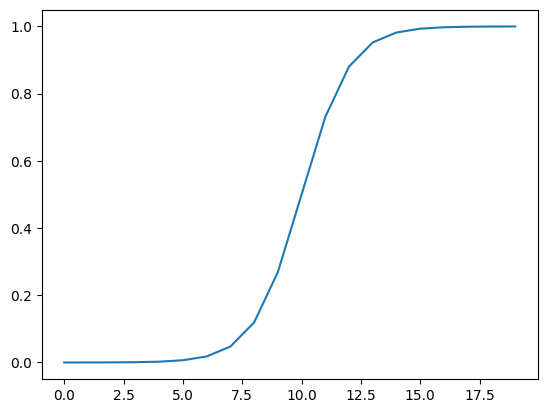

In [140]:
# Do the same for sigmoid
def sigmoid(x):
    return 1/(1+torch.exp(-x))

plt.plot(torch.sigmoid(A))

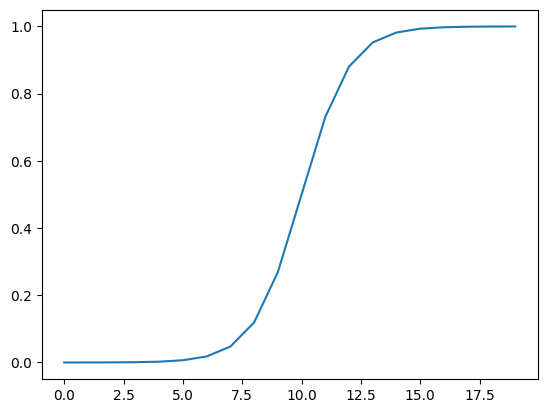

In [141]:
plt.plot(sigmoid(A))

## 8. Putting it all together with multi-class classification problem


### 8.1 Creating a toy multi-class dataset

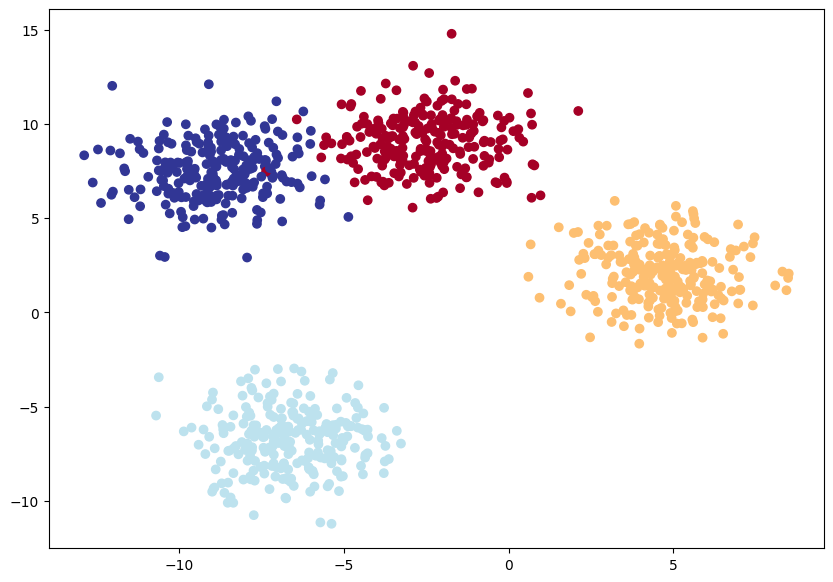

In [142]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # Give the cluster a little shakeup
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split it into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model

In [143]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [144]:
# Build the model
class BlobModel(nn.Module):
    def __init__(self,input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
# create an instance of the blob model
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer

In [145]:
# Create a loss function
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probs for the model
In order to evaluate and train and test the model we need to convert the model's output(logits) to prediction probs and then to preidction labels

In [146]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))
y_logits[:10], y_blob_test[:10]

(tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
         [ 1.7168, -1.2270,  1.7367,  2.1010],
         [ 2.2400,  0.7714,  2.6020,  1.0107],
         [-0.7993, -0.3723, -0.9138, -0.5388],
         [-0.4332, -1.6117, -0.6891,  0.6852],
         [ 2.0878, -1.3728,  2.1248,  2.5052],
         [ 1.8310,  0.8851,  2.1674,  0.6006],
         [ 0.1412, -1.4742, -0.0360,  1.0373],
         [ 2.9426,  0.7047,  3.3670,  1.6184],
         [-0.0645, -1.5006, -0.2666,  0.8940]], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]))

In [147]:
# Convert the model's logit outputs to prediction probs
y_pred_probs = torch.softmax(y_logits,dim=-1)
print(y_logits[:5])
print(y_pred_probs[:5])
y_logits.shape, y_logits.ndim

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0')
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0')


(torch.Size([200, 4]), 2)

In [148]:
# Converting prediction probs to labels
y_preds = torch.argmax(y_pred_probs,dim=1)

### 8.5 Creating a training loop and testing loop

In [149]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train, X_blob_test, y_blob_test = X_blob_train.to(device), y_blob_train.to(device), X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
    model_4.train()

    # Forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # loss
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # Zero grad the optimizer
    optimizer.zero_grad()

    # back prop
    loss.backward()

    # optimizer step
    optimizer.step()


    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_preds)

    # PRint out what is happening
    if epoch % 10 == 0:
        print(epoch, loss, acc, test_loss, test_acc)

0 tensor(1.0432, device='cuda:0', grad_fn=<NllLossBackward0>) 65.5 tensor(0.5786, device='cuda:0') 95.5
10 tensor(0.1440, device='cuda:0', grad_fn=<NllLossBackward0>) 99.125 tensor(0.1304, device='cuda:0') 99.0
20 tensor(0.0806, device='cuda:0', grad_fn=<NllLossBackward0>) 99.125 tensor(0.0722, device='cuda:0') 99.5
30 tensor(0.0592, device='cuda:0', grad_fn=<NllLossBackward0>) 99.125 tensor(0.0513, device='cuda:0') 99.5
40 tensor(0.0489, device='cuda:0', grad_fn=<NllLossBackward0>) 99.0 tensor(0.0410, device='cuda:0') 99.5
50 tensor(0.0429, device='cuda:0', grad_fn=<NllLossBackward0>) 99.0 tensor(0.0349, device='cuda:0') 99.5
60 tensor(0.0391, device='cuda:0', grad_fn=<NllLossBackward0>) 99.0 tensor(0.0308, device='cuda:0') 99.5
70 tensor(0.0364, device='cuda:0', grad_fn=<NllLossBackward0>) 99.0 tensor(0.0280, device='cuda:0') 99.5
80 tensor(0.0345, device='cuda:0', grad_fn=<NllLossBackward0>) 99.0 tensor(0.0259, device='cuda:0') 99.5
90 tensor(0.0330, device='cuda:0', grad_fn=<NllLos

### 8.6 Making and evaluating prediction with PyTorch multi-class model

In [150]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0726,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

In [151]:
# Go from logits to pred probs
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.4332e-03, 9.9757e-01, 1.0804e-11, 1.8271e-09],
        [3.4828e-03, 1.3698e-10, 6.8363e-04, 9.9583e-01],
        [2.8657e-12, 1.2267e-15, 9.9973e-01, 2.6959e-04],
        [3.2692e-03, 9.9673e-01, 9.5436e-08, 4.7620e-07],
        [9.9168e-01, 8.3089e-03, 1.4120e-10, 8.2969e-06],
        [4.5039e-04, 5.4288e-13, 2.5532e-04, 9.9929e-01],
        [1.6306e-11, 2.4030e-13, 9.9987e-01, 1.3003e-04],
        [9.9860e-01, 3.9485e-04, 5.9937e-08, 1.0045e-03],
        [3.0436e-14, 6.8305e-20, 9.9965e-01, 3.5218e-04],
        [9.9843e-01, 1.3657e-03, 9.0768e-09, 2.0006e-04]], device='cuda:0')

In [152]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [153]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

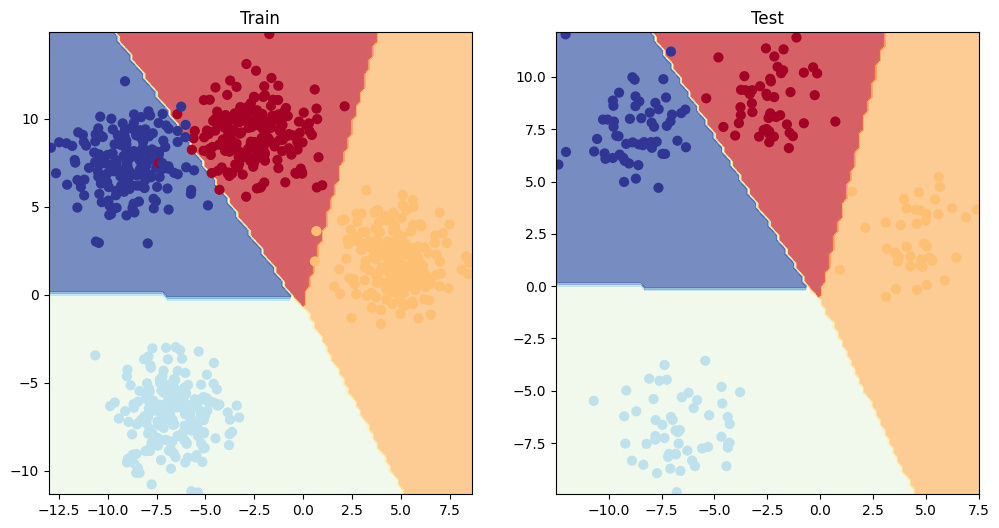

In [154]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)


## 9. A few more classification metrics...(to evaluate our classification model)

* Accuracy - out of 100 how many does our model get right.
* Precision
* F1 - score
* Confusion matrix
* Classification report

In [155]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 13.8 MB/s eta 0:00:00


In [160]:
from torchmetrics import Accuracy

# Set up metric
torchmetric_accuracy = Accuracy(task='MULTICLASS', num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')